##### Author:
    Diana Y. Lee, Luque Lab, SDSU
    dlee@sdsu.edu

##### Purpose:
    Creates a random forest model for predicting the capsid architecture (as measured by the T-number) 
    of a tailed phage from the MCP sequence
    Evaluates the accuracy of that model.
    Creates the base illustrations for Figure 6 of the paper in preparation: 
    Lee et al., Predicting the capsid architecture of tailed phages from metagenomic data

##### Requires: 
    PHAGE_TABLE4.xlsx : phage data with indexes, genome size, and translations
    PHAGE_TABLE3X.xlsx : 80% of phage data with indexes, genome size, and translations
    PHAGE_TABLE3Y.xlsx : 20% of phage data with indexes, genome size, and translations
    phage_functions.ipynb
    
    
##### Database file: 
    fig6_revisit_grid_search.db
    fig6_revisit_grid_search2.db
    
##### Creates:



In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(42)
import math
import os 
import copy
import csv
import time
import random
import statistics
import seaborn as sn

In [2]:
# ML imports
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.base import BaseEstimator
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn import metrics

In [3]:
from ipynb.fs.full.phage_functions import tNearest
from ipynb.fs.full.phage_functions import tNearestValid
from ipynb.fs.full.phage_functions import tModel
from ipynb.fs.full.phage_functions import tNum
from ipynb.fs.full.phage_functions import tList
from ipynb.fs.full.phage_functions import tDictAll

In [4]:
from Bio.SeqUtils.IsoelectricPoint import IsoelectricPoint as IP

In [5]:
# set the fontsize
font1 = 22
font2 = 18
font3 = 14

In [6]:
#create a list of possible, valid T-numbers, as well as separate t-number lists for T_h and T_t 
tps2, tps, tps_t, tps_h = tList(7)

# create T dictionaries
tdict2,tdict2rev = tDictAll(7)

# set the error margin
errMar = 0.09

# create a list of equivalent genome length for each T
tMod = tModel()
TDNA = np.exp((np.log(tps)-tMod[2])/tMod[0])

In [7]:
# custom function to count amino acids
# amino acids are hardcoded to avoid broken dependencies, since they do not change
def createFreq(acidSeq, normF=None):
    normF = normF or 0
    if (normF > 1):
        print("Valid tTypes are 0 (raw) or 1 (normalized by sample). Defaults to 0.")
        return
    AA = []
    aaList = np.asarray(['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V'])
    aaLen=len(aaList)
    n = len(acidSeq)
    for i in range(n):
        for acid in (aaList):
            trans1=str(acidSeq[i])
            a = trans1.count(str(acid))
            AA.append(a)
    rFreq = np.asarray(AA).reshape((n, aaLen))
    if (normF == 0):
#        print("Success! Created an nx20 array, where n is the length of the list provided:",n)
#        print("Columns are frequency totals for each amino acid:",aaList)
        return rFreq
    if (normF == 1):
        nFreq = copy.copy(rFreq).astype(float)
        fff3 = copy.copy(rFreq).astype(float)
        nf = rFreq.shape[1]
        for i in range(nf):
            nFreq[:,i] = fff3[:,i]/fff3.sum(axis=1)
#        print("Success! Created an nx20 array, where n is the length of the list provided:",n)
#        print("Columns are frequency percentages for each amino acid:",aaList)
        return nFreq

In [8]:
# custom function to create dataset with only sequence length, frequency, and isoelectric point
# requires a dataframe with fields "Virus_Name", MCP_Sequence","IPC", and "MCP_len"

def createDataset3(dF):
    nn=dF.shape[0]
    freq = createFreq(dF["MCP_Sequence"], 1)
    AAT = []
    for i in range(nn):
        AAT.append(dF.iloc[i]["Virus_ID"])
        AAT.append(dF.iloc[i]["IPC"])
        AAT.append(dF.iloc[i]["MCP_len"])
        for j in range(20):
            AAT.append(freq[i][j])
        AAT.append(dF.iloc[i]["T_nearest_errMar_code"])
    AAT = np.reshape(np.ravel(AAT), (nn, 24));
    AAT = np.asarray(AAT)

    
#    print("Success! Created an nx24 array, where n is the length of the list provided:",n)
#    print("Column 0: Virus_Name")
#    print("Column 1: Isoelectric Point")
#    print("Column 2: length of MCP sequence")
#    print("Columns 3-22 are frequency percentages for each amino acid")
#    print("Column 23: Target T")
    return AAT

In [9]:
# import phage data
phageData = pd.read_excel("../data/PHAGE_TABLE3X.xlsx")
# remove records from the dataframe if the ID is nan
for i in range(len(phageData["ID"])):
    if(np.isnan(phageData["ID"][i])):
        phageData = phageData.drop(index=i)
# get a count
n = len(phageData["ID"])
# change any necessary column names using this command, with the arguments formatted as {"original_column_name" : "New_name"}
phageData = phageData.rename(columns={"COMPLETE_GENOME_BP": 'genome_length',"PROTEIN_BP": 'MCP_len',"ID": 'Virus_ID','TRANSLATION':'MCP_Sequence'})


In [10]:
# calculate T numbers and isoelectric point
ny = phageData.shape[0]
Y_T = []

for i in range(ny):
    # ID
    Y_T.append(phageData.iloc[i]["Virus_ID"])
    # isoelectric point
    Y_T.append(IP(str(phageData.iloc[i]["MCP_Sequence"])).pi())
    # T raw
    Y_T.append(round(tNum(phageData.iloc[i]["genome_length"]/1000,0),4))
    # Check and see if the structure is on the High-Res list
    if(phageData.iloc[i]['HR data']=="x"):
        # T nearest
        Y_T.append(phageData.iloc[i]['HR_T'])
        # T nearest err mar
        Y_T.append(phageData.iloc[i]['HR_T'])
        # T nearest err mar code
        Y_T.append(tdict2[phageData.iloc[i]['HR_T']])
    else:
        # T nearest
        Y_T.append(tNum(phageData.iloc[i]["genome_length"]/1000,1))
        # T nearest err mar
        Y_T.append(tNum(phageData.iloc[i]["genome_length"]/1000,2,errMar))
        # T nearest err mar code
        Y_T.append(tdict2[tNum(phageData.iloc[i]["genome_length"]/1000,2,errMar)])
    
Y = np.asarray(Y_T)
Y = np.reshape(np.ravel(Y), (ny, 6));
Y = np.asarray(Y)

df_T = pd.DataFrame(Y)
df_T = df_T.rename(columns={0: 'Virus_ID', 1: 'IPC', 2: 'T_raw', 3: 'T_nearest', 4: 'T_nearest_errMar', 5: 'T_nearest_errMar_code'})

df_T["T_raw"] = df_T["T_raw"].astype('float64')
df_T["T_nearest"] = df_T["T_nearest"].astype('float64')
df_T["T_nearest_errMar"] = df_T["T_nearest_errMar"].astype('float64')
df_T["T_nearest_errMar_code"] = df_T["T_nearest_errMar_code"].astype('int64')
df_T["IPC"] = df_T["IPC"].astype('float64')

In [11]:
# add T predictions to the phage data
currentDataset = phageData.merge(df_T, how='left', on='Virus_ID')
currentDataset[0:5]

,Virus_ID,GBK_ID,CDS,DEFINITION,HR data,HR_T,LOCUS_COMPLETE_GENOME,genome_length,ORGANISM,NCBI_GENPEPT_PROTEIN_ID,PROTEIN_PRODUCT,GENE_LOCUS,MCP_len,MCP_Sequence,IPC,T_raw,T_nearest,T_nearest_errMar,T_nearest_errMar_code
0,0,1262521.3,bp:11683..12636,"Leuconostoc phage phiLNTR3, complete genome.",NaN,NaN,NC_024378_1_28015,28015,"Viruses; dsDNA viruses, no RNA stage; Caudovir...",YP_009044222.1,putative major capsid protein,HL53_gp15,317,MGIEFLSTSKAVELYAKLALETQGNTETFSRKWKDIVSERSEQAIT...,5.206759,5.2455,5.33,5.33,4
1,2,1282994.3,bp:13216..14253,"Burkholderia phage ST79, complete genome.",NaN,NaN,NC_021343_1_35430,35430,"Viruses; dsDNA viruses, no RNA stage; Caudovir...",YP_008060494.1,major capsid protein,M190_gp20,345,MNPITRRALTRYMDNIAKLNGVASVAEKFAVAPSVQQTLEKRIQES...,5.724960,6.2010,7.00,0.00,47
2,5,1168563.3,bp:5642..6655,"Stenotrophomonas phage Smp131, complete genome.",NaN,NaN,NC_023588_1_33525,33525,"Viruses; dsDNA viruses, no RNA stage; Caudovir...",YP_009008364.1,phage major capsid protein precursor,CH36_gp09,337,MRTKTRRLFEGYTQQVATLNNVSGVANTFSVEPTVQQSLEARMQES...,9.033197,5.9615,5.33,0.00,47
3,6,225588.1,bp:4228..5400,Bacteriophage phi-BT1,NaN,NaN,NC_004664_1_41831,41831,"Viruses; dsDNA viruses, no RNA stage; Caudovir...",NP_813696.1,Phage major capsid protein,phiBT1p05,390,MDATTLSANFEARERATAELRTLTDEFAGKEMTDEAREKEERLITA...,5.037720,6.9802,7.00,7.00,5
4,7,1406784.3,bp:9580..10470,"Bacillus phage Glittering, complete genome.",NaN,NaN,NC_022766_1_49246,49246,"Viruses; dsDNA viruses, no RNA stage; Caudovir...",YP_008770652.1,major capsid protein,Glittering_16,296,MADIVLGQHPLLKKVFLDRRIRDFTESGFIADQLFTGISVDALAIK...,4.959339,7.8410,7.00,0.00,47


In [12]:
# create the dataset for the random forest
x_Phage = createDataset3(currentDataset)

# assign the features and labels
x_actual = (x_Phage[0:ny,1:23]).astype(float)
y_actual = (x_Phage[0:ny,23]).astype(int)

In [14]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [15]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(x_actual,y_actual)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


C:\Users\nueve\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   36.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.3min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [16]:
rf_random.best_params_

{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 10,
 'bootstrap': False}

In [17]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [10, 15, 20],
    'max_features': [4, 6, 7, 8, 10, 12, 15, 'auto'],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 4, 6],
    'n_estimators': [250, 750, 1000, 1250, 1500],
    'class_weight': ['balanced','balanced subsample','None']
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [18]:
# Fit the grid search to the data
grid_search.fit(x_actual,y_actual)
grid_search.best_params_

best_grid = grid_search.best_estimator_

Fitting 3 folds for each of 6480 candidates, totalling 19440 fits


C:\Users\nueve\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done 3257 tasks      | elapsed: 16.5min
[Parallel(n_jobs=-1)]: Done 12135 tasks      | elapsed: 31.6min
[Parallel(n_jobs=-1)]: Done 13250 tasks      | elapsed: 37

In [19]:
grid_search.best_params_

{'bootstrap': True,
 'class_weight': 'balanced',
 'max_depth': 15,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 6,
 'n_estimators': 1500}

In [20]:
best_clfs = pd.DataFrame(grid_search.cv_results_).sort_values(by='mean_test_score',ascending=False)
best_clfs[:9]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_class_weight,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
3618,3.875973,0.274761,0.212100,0.019634,False,balanced,15,4,2,2,1250,"{'bootstrap': False, 'class_weight': 'balanced...",0.751479,0.798817,0.627219,0.725838,0.072363,1
3664,5.540036,0.348564,0.239693,0.006829,False,balanced,15,6,2,2,1500,"{'bootstrap': False, 'class_weight': 'balanced...",0.769231,0.781065,0.627219,0.725838,0.069902,1
689,4.064463,0.070974,0.241687,0.005543,True,balanced,15,auto,1,6,1500,"{'bootstrap': True, 'class_weight': 'balanced'...",0.745562,0.792899,0.639053,0.725838,0.064337,1
3563,3.996813,0.364422,0.224067,0.028505,False,balanced,10,auto,1,4,1250,"{'bootstrap': False, 'class_weight': 'balanced...",0.757396,0.786982,0.627219,0.723866,0.069399,4
3933,3.650164,0.117274,0.194812,0.014575,False,balanced,15,auto,2,2,1250,"{'bootstrap': False, 'class_weight': 'balanced...",0.757396,0.786982,0.627219,0.723866,0.069399,4
3667,4.390936,0.107522,0.196807,0.023746,False,balanced,15,6,2,4,1000,"{'bootstrap': False, 'class_weight': 'balanced...",0.763314,0.775148,0.633136,0.723866,0.064337,6
3240,0.692148,0.021219,0.037566,0.000470,False,balanced,10,4,1,2,250,"{'bootstrap': False, 'class_weight': 'balanced...",0.751479,0.786982,0.633136,0.723866,0.065773,6
3619,5.389603,0.511230,0.295543,0.029319,False,balanced,15,4,2,2,1500,"{'bootstrap': False, 'class_weight': 'balanced...",0.751479,0.781065,0.633136,0.721893,0.063913,8
9,3.762446,0.063412,0.216421,0.001629,True,balanced,10,4,1,4,1500,"{'bootstrap': True, 'class_weight': 'balanced'...",0.751479,0.786982,0.627219,0.721893,0.068496,8


In [21]:
# Create the random forest classifiers for the most useful feature/estimator combinations
rf1_clf = RandomForestClassifier(random_state = 42, max_features=best_clfs.iloc[0]["param_max_features"],n_estimators=best_clfs.iloc[0]["param_n_estimators"], max_depth=best_clfs.iloc[0]["param_max_depth"], min_samples_split=best_clfs.iloc[0]["param_min_samples_split"], min_samples_leaf=best_clfs.iloc[0]["param_min_samples_leaf"],bootstrap = True, class_weight='balanced')
rf2_clf = RandomForestClassifier(random_state = 42, max_features=best_clfs.iloc[1]["param_max_features"],n_estimators=best_clfs.iloc[1]["param_n_estimators"], max_depth=best_clfs.iloc[1]["param_max_depth"], min_samples_split=best_clfs.iloc[1]["param_min_samples_split"], min_samples_leaf=best_clfs.iloc[1]["param_min_samples_leaf"],bootstrap = True, class_weight='balanced')
rf3_clf = RandomForestClassifier(random_state = 42, max_features=best_clfs.iloc[2]["param_max_features"],n_estimators=best_clfs.iloc[2]["param_n_estimators"], max_depth=best_clfs.iloc[2]["param_max_depth"], min_samples_split=best_clfs.iloc[2]["param_min_samples_split"], min_samples_leaf=best_clfs.iloc[2]["param_min_samples_leaf"],bootstrap = True, class_weight='balanced')
rf4_clf = RandomForestClassifier(random_state = 42, max_features=best_clfs.iloc[3]["param_max_features"],n_estimators=best_clfs.iloc[3]["param_n_estimators"], max_depth=best_clfs.iloc[3]["param_max_depth"], min_samples_split=best_clfs.iloc[3]["param_min_samples_split"], min_samples_leaf=best_clfs.iloc[3]["param_min_samples_leaf"],bootstrap = True, class_weight='balanced')
rf5_clf = RandomForestClassifier(random_state = 42, max_features=best_clfs.iloc[4]["param_max_features"],n_estimators=best_clfs.iloc[4]["param_n_estimators"], max_depth=best_clfs.iloc[4]["param_max_depth"], min_samples_split=best_clfs.iloc[4]["param_min_samples_split"], min_samples_leaf=best_clfs.iloc[4]["param_min_samples_leaf"],bootstrap = True, class_weight='balanced')
rf6_clf = RandomForestClassifier(random_state = 42, max_features=best_clfs.iloc[5]["param_max_features"],n_estimators=best_clfs.iloc[5]["param_n_estimators"], max_depth=best_clfs.iloc[5]["param_max_depth"], min_samples_split=best_clfs.iloc[5]["param_min_samples_split"], min_samples_leaf=best_clfs.iloc[5]["param_min_samples_leaf"],bootstrap = True, class_weight='balanced')
rf7_clf = RandomForestClassifier(random_state = 42, max_features=best_clfs.iloc[6]["param_max_features"],n_estimators=best_clfs.iloc[6]["param_n_estimators"], max_depth=best_clfs.iloc[6]["param_max_depth"], min_samples_split=best_clfs.iloc[6]["param_min_samples_split"], min_samples_leaf=best_clfs.iloc[6]["param_min_samples_leaf"],bootstrap = True, class_weight='balanced')
rf8_clf = RandomForestClassifier(random_state = 42, max_features=best_clfs.iloc[7]["param_max_features"],n_estimators=best_clfs.iloc[7]["param_n_estimators"], max_depth=best_clfs.iloc[7]["param_max_depth"], min_samples_split=best_clfs.iloc[7]["param_min_samples_split"], min_samples_leaf=best_clfs.iloc[7]["param_min_samples_leaf"],bootstrap = True, class_weight='balanced')
rf9_clf = RandomForestClassifier(random_state = 42, max_features=best_clfs.iloc[8]["param_max_features"],n_estimators=best_clfs.iloc[8]["param_n_estimators"], max_depth=best_clfs.iloc[8]["param_max_depth"], min_samples_split=best_clfs.iloc[8]["param_min_samples_split"], min_samples_leaf=best_clfs.iloc[8]["param_min_samples_leaf"],bootstrap = True, class_weight='balanced')

# create a voting classifer for all of the random forests
voting_clf = VotingClassifier(
    estimators=[('rf1', rf1_clf), ('rf2', rf2_clf), ('rf3', rf3_clf), ('rf4', rf4_clf), ('rf5', rf5_clf), ('rf6', rf6_clf), ('rf7', rf7_clf), ('rf8', rf8_clf), ('rf9', rf9_clf)],
    voting='hard')

In [206]:
# import phage data
holdoutData = pd.read_excel("../data/PHAGE_TABLE3Y.xlsx")
# remove records from the dataframe if the ID is nan
for i in range(len(holdoutData["ID"])):
    if(np.isnan(holdoutData["ID"][i])):
        holdoutData = holdoutData.drop(index=i)
# get a count
nh = len(holdoutData["ID"])
# change any necessary column names using this command, with the arguments formatted as {"original_column_name" : "New_name"}
holdoutData = holdoutData.rename(columns={"COMPLETE_GENOME_BP": 'genome_length',"PROTEIN_BP": 'MCP_len',"ID": 'Virus_ID','TRANSLATION':'MCP_Sequence'})


In [207]:
# calculate T numbers and isoelectric point
ny = holdoutData.shape[0]
Y_T = []

for i in range(ny):
    # ID
    Y_T.append(holdoutData.iloc[i]["Virus_ID"])
    # isoelectric point
    Y_T.append(IP(str(holdoutData.iloc[i]["MCP_Sequence"])).pi())
    # T raw
    Y_T.append(round(tNum(holdoutData.iloc[i]["genome_length"]/1000,0),4))
    # Check and see if the structure is on the High-Res list
    if(holdoutData.iloc[i]['HR data']=="x"):
        # T nearest
        Y_T.append(holdoutData.iloc[i]['HR_T'])
        # T nearest err mar
        Y_T.append(holdoutData.iloc[i]['HR_T'])
        # T nearest err mar code
        Y_T.append(tdict2[holdoutData.iloc[i]['HR_T']])
    else:
        # T nearest
        Y_T.append(tNum(holdoutData.iloc[i]["genome_length"]/1000,1))
        # T nearest err mar
        Y_T.append(tNum(holdoutData.iloc[i]["genome_length"]/1000,2,errMar))
        # T nearest err mar code
        Y_T.append(tdict2[tNum(holdoutData.iloc[i]["genome_length"]/1000,2,errMar)])
    
Y = np.asarray(Y_T)
Y = np.reshape(np.ravel(Y), (ny, 6));
Y = np.asarray(Y)

df_T = pd.DataFrame(Y)
df_T = df_T.rename(columns={0: 'Virus_ID', 1: 'IPC', 2: 'T_raw', 3: 'T_nearest', 4: 'T_nearest_errMar', 5: 'T_nearest_errMar_code'})

df_T["T_raw"] = df_T["T_raw"].astype('float64')
df_T["T_nearest"] = df_T["T_nearest"].astype('float64')
df_T["T_nearest_errMar"] = df_T["T_nearest_errMar"].astype('float64')
df_T["T_nearest_errMar_code"] = df_T["T_nearest_errMar_code"].astype('int64')
df_T["IPC"] = df_T["IPC"].astype('float64')

In [208]:
# add T predictions to the phage data
holdoutDataset = holdoutData.merge(df_T, how='left', on='Virus_ID')
holdoutDataset[0:5]

,Virus_ID,GBK_ID,CDS,DEFINITION,HR data,HR_T,LOCUS_COMPLETE_GENOME,genome_length,ORGANISM,NCBI_GENPEPT_PROTEIN_ID,PROTEIN_PRODUCT,GENE_LOCUS,MCP_len,MCP_Sequence,IPC,T_raw,T_nearest,T_nearest_errMar,T_nearest_errMar_code
0,1,1273740.3,bp:9604..10494,"Bacillus phage Curly, complete genome.",NaN,NaN,NC_020479_1_49425,49425,"Viruses; dsDNA viruses, no RNA stage; Caudovir...",YP_007517560.1,major capsid protein,CURLY_16,296,MADIVLGQHPLLKKVFLDRRIKDFTASGFVADQLFTNISVDALAIK...,4.942344,7.8613,7.00,0.0,47
1,3,633135.2,bp:4469..5662,Streptococcus phage Abc2,NaN,NaN,NC_013645_1_34882,34882,"Viruses; dsDNA viruses, no RNA stage; Caudovir...",YP_003347415.1,Phage major capsid protein # ACLAME 20,SP-Abc2_gp06,397,MKTSNELHDLWVAQGDKVENLNEKLNVAMLDDSVTAEELQKIKNER...,5.111894,6.1325,5.33,0.0,47
2,12,1527580.3,bp:5047..5868,"Mycobacterium phage Inventum, complete genome.",NaN,NaN,NC_026596_1_57052,57052,"Viruses; dsDNA viruses, no RNA stage; Caudovir...",YP_009125287.1,major capsid protein,VC69_gp006,273,MAFNNFIPELWSDMLLEEWAAQTVFANLVNREYEGIANKGNVVHIA...,4.538162,8.7079,9.00,9.0,6
3,19,10713.3,bp:6161..7186,"Enterobacteria phage phi80, complete genome.",NaN,NaN,NC_021190_1_46150,46150,"Viruses; dsDNA viruses, no RNA stage; Caudovir...",YP_007947932.1,major capsid (head) protein,ABF05_gp07,341,MSVYTTAQLLAVNEKKFKFDPLFLRIFFRETYPFSTEKVYLSQIPG...,6.083386,7.4865,7.00,7.0,5
4,29,1476390.3,bp:7122..8096,"Pseudomonas phage vB PaeS SCH Ab26, complete g...",NaN,NaN,NC_024381_1_43056,43056,"Viruses; dsDNA viruses, no RNA stage; Caudovir...",YP_009044345.1,major capsid protein,HL17_gp10,324,MALSDLAVYSEYAYSAFSETLRQQVDLFNAATGGAIMLQSAAHQGD...,4.934784,7.1252,7.00,7.0,5


In [66]:
# create the random forest dataset for the holdout database 
xTestH_Phage = createDataset3(holdoutDataset)

# assign the features and labels
xTestH_actual = (xTestH_Phage[0:ny,1:23]).astype(float)
yTestH_actual = (xTestH_Phage[0:ny,23]).astype(int)

n_featH = xTestH_actual.shape[1]

In [68]:
# run the top ten random forest for 80/20 train/test splits on the holdout database
# that is, use the optimized hyperparameters to train on a randomly selected 80% of the data
# then check the accuracy on the remaining 20%

# set number of iterations
n_iter = 100
# for each of the classifiers
n_clf = 10
results_RF = []

for i in range(n_iter):
    # create a random shuffle of the phage table data
    shuffle_index = np.random.permutation(nh)
    xS,yS = xTestH_actual[shuffle_index], yTestH_actual[shuffle_index]

    # split into an 80/20 training set
    n80 = round(nh*.80)
    n20 = nh-n80
    x_train, x_test = xS[:n80], xS[n80:]
    y_train, y_test = yS[:n80], yS[n80:]

    # review the accuracy of all of the random forests 
    for clf in (rf1_clf, rf2_clf, rf3_clf, rf4_clf,rf5_clf,rf6_clf, rf7_clf,rf8_clf,rf9_clf,voting_clf):
        clf.fit(x_train, y_train)
        yPred = clf.predict(x_test)
        forest_mse2 = mean_squared_error(y_test, yPred)
        results_RF.append(accuracy_score(y_test, yPred))
        #print(clf)
        #print(clf.__class__.__name__, "Accuracy: ", accuracy_score(y_test, yPred), "MSE: ",forest_mse2)
    if (i % 10 == 0):
        print('loop ',i)
        
allResultsH = np.reshape(np.ravel(results_RF), (n_iter, n_clf));
allResultsH = np.asarray(allResults);
allResultsH = pd.DataFrame(allResults,columns=['rf1_clf', 'rf2_clf', 'rf3_clf', 'rf4_clf', 'rf5_clf', 'rf6_clf', 'rf7_clf', 'rf8_clf', 'rf9_clf', 'voting_clf'])


loop  0
loop  10
loop  20
loop  30
loop  40
loop  50
loop  60
loop  70
loop  80
loop  90


In [69]:
# look at the average accuracy for each classifier
for column in allResultsH.columns[0:]:
    print(np.mean(allResultsH[column]))

0.718110236220472
0.7223622047244092
0.7172440944881887
0.7169291338582674
0.718110236220472
0.7222047244094489
0.7140944881889763
0.7170866141732283
0.7169291338582672
0.7188976377952753


In [209]:
# identify the one that did the best
rfBest_clf=rf2_clf
print("rfBest_clf=rf2_clf")
print("RandomForestClassifier")
print("random_state= 42")
print("max_features= ", best_clfs.iloc[1]["param_max_features"])
print("n_estimators= ", best_clfs.iloc[1]["param_n_estimators"]) 
print("max_depth=",best_clfs.iloc[1]["param_max_depth"]) 
print("min_samples_split=",best_clfs.iloc[1]["param_min_samples_split"])
print("min_samples_leaf=",best_clfs.iloc[1]["param_min_samples_leaf"])
print("bootstrap = True")
print("class_weight=balanced")

rfBest_clf=rf2_clf
RandomForestClassifier
random_state= 42
max_features=  6
n_estimators=  1500
max_depth= 15
min_samples_split= 2
min_samples_leaf= 2
bootstrap = True
class_weight=balanced


In [220]:
# let's go back to the holdout data for a confusion matrix
rfBest_clf.fit(x_actual, y_actual)
yH_Pred = rfBest_clf.predict(xTestH_actual)
yH_expected = yHoldout_actual
print(metrics.classification_report(yH_expected,yH_Pred))
yH_cmRF = confusion_matrix(yH_expected,yH_Pred)
yH_rfBest_acc = accuracy_score(yH_expected, yH_Pred)
print(yH_cmRF)
holdout_Accuracy = rfBest_clf.__class__.__name__, accuracy_score(yH_expected, yH_Pred)
print("Accuracy Score:", holdout_Accuracy)

              precision    recall  f1-score   support

           3       0.50      0.33      0.40         3
           4       1.00      0.33      0.50         3
           5       0.63      0.95      0.76        41
           6       0.57      0.31      0.40        13
           7       0.00      0.00      0.00         2
           8       1.00      0.40      0.57         5
           9       1.00      0.50      0.67         2
          10       0.71      0.83      0.77         6
          11       0.73      0.89      0.80         9
          12       0.86      0.80      0.83        15
          13       0.00      0.00      0.00         1
          14       1.00      1.00      1.00         1
          15       1.00      0.50      0.67         2
          19       1.00      1.00      1.00         1
          30       0.00      0.00      0.00         1
          47       0.56      0.43      0.49        23

    accuracy                           0.67       128
   macro avg       0.66   

C:\Users\nueve\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [196]:
# make a unique list of all T nums in the confusion matrix
blerb= np.unique(np.concatenate([(yH_expected), (yH_Pred)]))

blerb

array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 19, 30, 47])

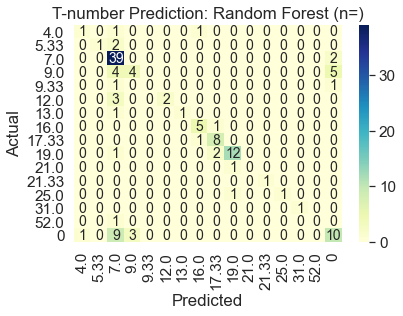

0.671875

In [211]:
fig = plt.figure()
t_labels=[]
for i in range (len(blerb)):
    t_labels.append(tdict2rev[blerb[i]])
t_labels

# print(cm)
df_cm = pd.DataFrame(yH_cmRF, index=[blerb],
                  columns=[blerb], )
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 14},cmap="YlGnBu",yticklabels=t_labels,xticklabels=t_labels)# font size
plt.title("T-number Prediction: Random Forest (n=)") 
plt.xlabel("Predicted")
plt.ylabel("Actual")

fig.savefig('../results/Fig4SI-statSim01.svg')
fig.savefig('../results/Fig4SI-statSim01.png')
plt.show()

accuracy_score(yH_expected,yH_Pred, normalize=True, sample_weight=None)

In [198]:
# create a placeholder for the cm result verification
tResult=[]
# for each T-number
for i in range(len(blerb)):
    # T-number
    tResult.append(tdict2rev[blerb[i]])
    # true positives
    tResult.append(yH_cmRF[i][i])
    # false positives
    tResult.append(np.sum(yH_cmRF[:,i])-yH_cmRF[i][i])
    # false negatives
    tResult.append(np.sum(yH_cmRF[i,:])-yH_cmRF[i][i])
    # true negatives
    tResult.append(np.sum(yH_cmRF)-np.sum(yH_cmRF[i,:])-np.sum(yH_cmRF[:,i])+yH_cmRF[i][i])
#    # precision
#    if (np.sum(yH_cmRF[:,i])>0):
#        tResult.append((yH_cmRF[i][i])/np.sum(yH_cmRF[:,i]))
#    else:
#        tResult.append(0)
#    # recall
#    if (np.sum(yH_cmRF[i,:])>0):
#        tResult.append((yH_cmRF[i][i])/np.sum(yH_cmRF[i,:]))
#    else:
#        tResult.append(0)
    
tResult=np.asarray(tResult).reshape(-1,5)
#tResult=np.asarray(tResult).reshape(-1,7)
print("T-num  --  TP --  FP --  FN -- TN")
#print("T-num  --  TP --  FP --  FN -- TN -- Precision - Recall")
print(tResult)

T-num  --  TP --  FP --  FN -- TN
[[  4.     1.     1.     2.   124.  ]
 [  5.33   1.     0.     2.   125.  ]
 [  7.    39.    23.     2.    64.  ]
 [  9.     4.     3.     9.   112.  ]
 [  9.33   0.     0.     2.   126.  ]
 [ 12.     2.     0.     3.   123.  ]
 [ 13.     1.     0.     1.   126.  ]
 [ 16.     5.     2.     1.   120.  ]
 [ 17.33   8.     3.     1.   116.  ]
 [ 19.    12.     2.     3.   111.  ]
 [ 21.     0.     0.     1.   127.  ]
 [ 21.33   1.     0.     0.   127.  ]
 [ 25.     1.     0.     1.   126.  ]
 [ 31.     1.     0.     0.   127.  ]
 [ 52.     0.     0.     1.   127.  ]
 [  0.    10.     8.    13.    97.  ]]


In [137]:
# create a placeholder for the cm result verification
tResult2=[]
# for each T-number
for i in range(len(blerb)):
    # T-number
    tResult2.append(tdict2rev[blerb[i]])
    # true positives
    tResult2.append(yH_cmRF[i][i])
    if (np.sum(yH_cmRF[i,:])==0):
        tResult2.append(0)
    else:
        tResult2.append((yH_cmRF[i][i])/np.sum(yH_cmRF[i,:]))   
    # false positives
    tResult2.append(np.sum(yH_cmRF[:,i])-yH_cmRF[i][i])
    if (np.sum(yH_cmRF[i,:])==0):
        tResult2.append(0)
    else:
        tResult2.append((np.sum(yH_cmRF[:,i])-yH_cmRF[i][i])/np.sum(yH_cmRF[i,:]))   
    # false negatives
    tResult2.append(np.sum(yH_cmRF[i,:])-yH_cmRF[i][i])
    if (np.sum(yH_cmRF[i,:])==0):
        tResult2.append(0)
    else:
        tResult2.append((np.sum(yH_cmRF[i,:])-yH_cmRF[i][i])/np.sum(yH_cmRF[i,:]))   
    # true negatives
    tResult2.append(np.sum(yH_cmRF)-np.sum(yH_cmRF[i,:])-np.sum(yH_cmRF[:,i])+yH_cmRF[i][i])
    if (np.sum(yH_cmRF)==0):
        tResult2.append(0)
    else:
        tResult2.append((np.sum(yH_cmRF)-np.sum(yH_cmRF[i,:])-np.sum(yH_cmRF[:,i])+yH_cmRF[i][i])/np.sum(yH_cmRF))
#    # precision
#    if (np.sum(yH_cmRF[:,i])>0):
#        tResult.append((yH_cmRF[i][i])/np.sum(yH_cmRF[:,i]))
#    else:
#        tResult.append(0)
#    # recall
#    if (np.sum(yH_cmRF[i,:])>0):
#        tResult.append((yH_cmRF[i][i])/np.sum(yH_cmRF[i,:]))
#    else:
#        tResult.append(0)
    
tResult2=np.asarray(tResult2).reshape(-1,9)
print("T-num  --  TP  --  TP%  --  FP  --  FP% --  FN  --  FN% -- TN  --  TN%")
#print("T-num  --  TP --  FP --  FN -- TN -- Precision - Recall")
np.set_printoptions(precision=3,suppress=True)
print(tResult2)
holdout_avg_tp = np.mean(pd.DataFrame(tResult2)[2])

T-num  --  TP  --  TP%  --  FP  --  FP% --  FN  --  FN% -- TN  --  TN%
[[  4.      1.      0.333   1.      0.333   2.      0.667 124.      0.969]
 [  5.33    1.      0.333   0.      0.      2.      0.667 125.      0.977]
 [  7.     39.      0.951  23.      0.561   2.      0.049  64.      0.5  ]
 [  9.      4.      0.308   3.      0.231   9.      0.692 112.      0.875]
 [  9.33    0.      0.      0.      0.      2.      1.    126.      0.984]
 [ 12.      2.      0.4     0.      0.      3.      0.6   123.      0.961]
 [ 13.      1.      0.5     0.      0.      1.      0.5   126.      0.984]
 [ 16.      5.      0.833   2.      0.333   1.      0.167 120.      0.938]
 [ 17.33    8.      0.889   3.      0.333   1.      0.111 116.      0.906]
 [ 19.     12.      0.8     2.      0.133   3.      0.2   111.      0.867]
 [ 21.      0.      0.      0.      0.      1.      1.    127.      0.992]
 [ 21.33    1.      1.      0.      0.      0.      0.    127.      0.992]
 [ 25.      1.      0.5     0

In [138]:
print("Avg TP", round(np.mean(tResult2[:,2]),4))
print("Avg FP", round(np.mean(tResult2[:,4]),4))
print("Avg FN", round(np.mean(tResult2[:,6]),4))
print("Avg TN", round(np.mean(tResult2[:,8]),4))

Avg TP 0.5177
Avg FP 0.1421
Avg FN 0.4823
Avg TN 0.917


In [199]:
h_acc = np.round((holdout_Accuracy[1]*100),1)

acc_str = 'Accuracy: ' + str(h_acc) + "%"
acc_str

'Accuracy: 67.2%'

In [140]:
FP = yH_cmRF.sum(axis=0) - np.diag(yH_cmRF)  
FN = yH_cmRF.sum(axis=1) - np.diag(yH_cmRF)
TP = np.diag(yH_cmRF)
TN = yH_cmRF.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)
# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

<ipython-input-140-fe7a35fa7036>:16: RuntimeWarning: invalid value encountered in true_divide
  PPV = TP/(TP+FP)
<ipython-input-140-fe7a35fa7036>:24: RuntimeWarning: invalid value encountered in true_divide
  FDR = FP/(TP+FP)


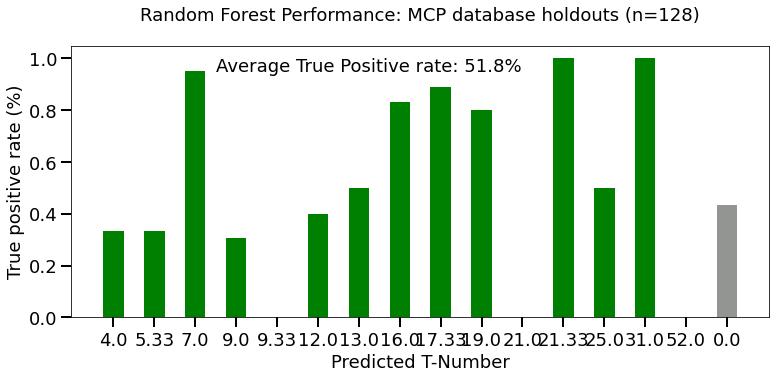

In [141]:
ind = np.arange(len(tResult[:,0]))    # the x locations for the groups
width = 0.5 

# create a color map to make the 'No T' group gray
barColors = []
for p in ind:
    if (p==np.max(ind)):
        barColors.append('#929591')
    else:
        barColors.append('green')
barColors = np.asarray(barColors)  

# plot the histogram
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12.5,5))
ax.set_facecolor('xkcd:white')
plt.xlabel('Predicted T-Number', fontsize=font2)
plt.ylabel('True positive rate (%)', fontsize=font2)
ax.set_title('Random Forest Performance: MCP database holdouts (n=' + str(xHoldout_Phage.shape[0]) + ")", fontsize=font2, pad=25)
h_tp = np.round((holdout_avg_tp*100),1)
acc_str = 'Average True Positive rate: ' + str(h_tp) + "%"

plt.text(2.5,.95, acc_str, {'fontsize': font2})


plt.bar(ind, TPR, width, align='center',color=barColors)
plt.xticks(ind, tResult[:,0], fontsize=font2)
#plt.xticks(ind, objects2, fontsize=font2, rotation=45)
plt.yticks(fontsize=font2)
ax.tick_params(length=10, width=2)


In [221]:
importances = rfBest_clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfBest_clf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(x_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 1 (0.080632)
2. feature 15 (0.078997)
3. feature 4 (0.063522)
4. feature 18 (0.061999)
5. feature 9 (0.059097)
6. feature 2 (0.054526)
7. feature 5 (0.054389)
8. feature 20 (0.049840)
9. feature 11 (0.048900)
10. feature 13 (0.044972)
11. feature 12 (0.042056)
12. feature 10 (0.040574)
13. feature 3 (0.038335)
14. feature 16 (0.036362)
15. feature 19 (0.035033)
16. feature 17 (0.034853)
17. feature 0 (0.034448)
18. feature 14 (0.030765)
19. feature 21 (0.030506)
20. feature 8 (0.030419)
21. feature 7 (0.028812)
22. feature 6 (0.020964)


In [216]:
print("Features Indices:")
print("Column 0: Isoelectric Point")
print("Column 1: length of MCP sequence")
print("Columns 2-21 are frequency percentages for each amino acid")
aa = np.asarray(['IP','len','A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V'])
print(aa)

Features Indices:
Column 0: Isoelectric Point
Column 1: length of MCP sequence
Columns 2-21 are frequency percentages for each amino acid
['IP' 'len' 'A' 'R' 'N' 'D' 'C' 'Q' 'E' 'G' 'H' 'I' 'L' 'K' 'M' 'F' 'P'
 'S' 'T' 'W' 'Y' 'V']


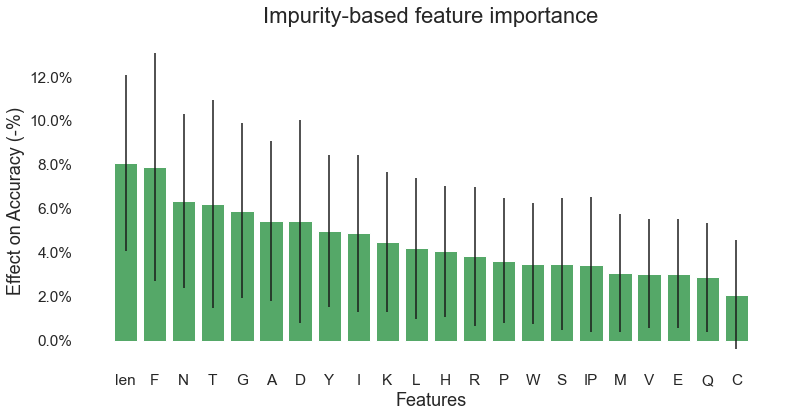

In [232]:
# Plot the feature importances of the forest

from matplotlib.ticker import PercentFormatter

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12.5, 6))
plt.bar(range(x_train.shape[1]), importances[indices],
       color="g", yerr=std[indices], align="center")
plt.xlabel('Features', fontsize=font2)
plt.ylabel('Effect on Accuracy (-%)', fontsize=font2)
ax.set_title('Impurity-based feature importance', fontsize=font1, pad=15)
ax.patch.set_facecolor('white')
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))
plt.grid(None)
plt.xticks(range(x_train.shape[1]), aa[indices])


plt.show()

fig.savefig("../results/Fig5b-RF impurity-based feature importance.png")
fig.savefig("../results/Fig5b-RF impurity-based feature importance.svg")


In [430]:
# import all phage data
testData = pd.read_excel("../data/PHAGE_TABLE4.xlsx")
# remove records from the dataframe if the ID is nan
for i in range(len(testData["ID"])):
    if(np.isnan(testData["ID"][i])):
        testData = testData.drop(index=i)
# get a count
nt = len(testData["ID"])
# change any necessary column names using this command, with the arguments formatted as {"original_column_name" : "New_name"}
testData = testData.rename(columns={"COMPLETE_GENOME_BP": 'genome_length',"PROTEIN_BP": 'MCP_len',"ID": 'Virus_ID','TRANSLATION':'MCP_Sequence'})


In [431]:
# calculate T numbers and isoelectric point
ny = testData.shape[0]
Y_T = []

for i in range(ny):
    # ID
    Y_T.append(testData.iloc[i]["Virus_ID"])
    # isoelectric point
    Y_T.append(IP(str(testData.iloc[i]["MCP_Sequence"])).pi())
    # T raw
    Y_T.append(round(tNum(testData.iloc[i]["genome_length"]/1000,0),4))
    # Check and see if the structure is on the High-Res list
    if(testData.iloc[i]['HR data']=="x"):
        # T nearest
        Y_T.append(testData.iloc[i]['HR_T'])
        # T nearest err mar
        Y_T.append(testData.iloc[i]['HR_T'])
        # T nearest err mar code
        Y_T.append(tdict2[testData.iloc[i]['HR_T']])
    else:
        # T nearest
        Y_T.append(tNum(testData.iloc[i]["genome_length"]/1000,1))
        # T nearest err mar
        Y_T.append(tNum(testData.iloc[i]["genome_length"]/1000,2,errMar))
        # T nearest err mar code
        Y_T.append(tdict2[tNum(testData.iloc[i]["genome_length"]/1000,2,errMar)])
    
Y = np.asarray(Y_T)
Y = np.reshape(np.ravel(Y), (ny, 6));
Y = np.asarray(Y)

df_T = pd.DataFrame(Y)
df_T = df_T.rename(columns={0: 'Virus_ID', 1: 'IPC', 2: 'T_raw', 3: 'T_nearest', 4: 'T_nearest_errMar', 5: 'T_nearest_errMar_code'})

df_T["T_raw"] = df_T["T_raw"].astype('float64')
df_T["T_nearest"] = df_T["T_nearest"].astype('float64')
df_T["T_nearest_errMar"] = df_T["T_nearest_errMar"].astype('float64')
df_T["T_nearest_errMar_code"] = df_T["T_nearest_errMar_code"].astype('int64')
df_T["IPC"] = df_T["IPC"].astype('float64')

In [432]:
# add T predictions to the phage data
testDataset = testData.merge(df_T, how='left', on='Virus_ID')
testDataset.shape

(635, 16)

In [433]:
# create the random forest dataset for the full database 
xTest_Phage = createDataset3(testDataset)

# assign the features and labels
xTest_actual = (xTest_Phage[0:ny,1:23]).astype(float)
yTest_actual = (xTest_Phage[0:ny,23]).astype(int)

n_feat = xTest_actual.shape[1]

In [434]:
# use the optimized hyperparameters to train on a randomly selected 80% of the data
# then check the accuracy on the remaining 20%

# set number of iterations
n_iter = 100
# for each of the classifiers
results_RF = []
cm_list = []
cm_report_list = []

for i in range(n_iter):
    # create a random shuffle of the phage table data
    shuffle_index = np.random.permutation(nt)
    xS,yS = xTest_actual[shuffle_index], yTest_actual[shuffle_index]
   
    # split into an 80/20 training set
    n80 = round(nt*.80)
    n20 = nt-n80
    x_train, x_test = xS[:n80], xS[n80:]
    y_train, y_test = yS[:n80], yS[n80:]

    # review the accuracy of the selected random forest 
    rfBest_clf.fit(x_train, y_train)
    yPred = rfBest_clf.predict(x_test)
    forest_mse2 = mean_squared_error(y_test, yPred)
    results_RF.append(accuracy_score(y_test, yPred))
        
    if (i % 10 == 0):
        print('loop ',i)

print("Average accuracy across %d iterations: %.2f" % (n_iter,np.mean(results_RF)))


loop  0
loop  10
loop  20
loop  30
loop  40
loop  50
loop  60
loop  70
loop  80
loop  90
Average accuracy across 100 iterations: 0.72


In [187]:
# saves kernel state
import dill
dill.dump_session('fig6_revisit_grid_search1.db')

In [248]:
# Run Permutation Feature Importance Analysis

# set number of iterations
n_iter = 100
# number of features
n_feat = xTest_actual.shape[1]
# create a placeholder for the results
perm_acc = np.zeros((n_iter, n_feat))


# for each of the features
for j in range(n_feat):

    for i in range(n_iter):

        # create a random shuffle of the phage table data
        shuffle_index = np.random.permutation(xTest_actual.shape[0])
        xS,yS = xTest_actual[shuffle_index], yTest_actual[shuffle_index]

        # split into an 80/20 training set
        n80 = round(nt*.80)
        n20 = nt-n80
        x_train, x_test = xS[:n80], xS[n80:]
        y_train, y_test = yS[:n80], yS[n80:]

        # create another shuffle index for the current feature
        shuf_ind = np.random.permutation(x_train.shape[0])
        # shuffle one column
        x_train[:,j] = x_train[:,j][shuf_ind]

        # train and fit the random forest
        rfBest_clf.fit(x_train,y_train)
        expected2 = y_test
        predicted2 = rfBest_clf.predict(x_test)
        curr_Accuracy = accuracy_score(expected2, predicted2)

        # compare accuracy to baseline
        perm_acc[i,j] = np.abs(curr_Accuracy-rfBest_acc)/rfBest_acc

    print("feat ", j, "complete")



feat  0 complete
feat  1 complete
feat  2 complete
feat  3 complete
feat  4 complete
feat  5 complete
feat  6 complete
feat  7 complete
feat  8 complete
feat  9 complete
feat  10 complete
feat  11 complete
feat  12 complete
feat  13 complete
feat  14 complete
feat  15 complete
feat  16 complete
feat  17 complete
feat  18 complete
feat  19 complete
feat  20 complete
feat  21 complete


In [252]:
perm_acc_df = pd.DataFrame(perm_acc)
feat_Columns = ["Isoelectric_Point","MCP len",'A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
perm_acc_df.columns = feat_Columns
perm_acc_df[0:5]

,Isoelectric_Point,MCP len,A,R,N,D,C,Q,E,G,...,L,K,M,F,P,S,T,W,Y,V
0,0.007874,0.054752,0.101630,0.113349,0.101630,0.113349,0.136788,0.101630,0.066471,0.043032,...,0.003845,0.066471,0.066471,0.078191,0.066471,0.113349,0.066471,0.019593,0.113349,0.101630
1,0.078191,0.007874,0.136788,0.066471,0.039004,0.043032,0.078191,0.148508,0.136788,0.066471,...,0.043032,0.113349,0.031313,0.101630,0.113349,0.101630,0.183666,0.043032,0.125069,0.031313
2,0.054752,0.078191,0.054752,0.136788,0.089910,0.160227,0.039004,0.019593,0.066471,0.148508,...,0.125069,0.125069,0.027284,0.043032,0.101630,0.019593,0.031313,0.078191,0.007874,0.089910
3,0.089910,0.003845,0.054752,0.054752,0.043032,0.078191,0.078191,0.078191,0.148508,0.043032,...,0.007874,0.054752,0.003845,0.043032,0.062443,0.031313,0.031313,0.078191,0.043032,0.019593
4,0.148508,0.019593,0.019593,0.066471,0.066471,0.031313,0.078191,0.066471,0.101630,0.218824,...,0.113349,0.043032,0.136788,0.207105,0.007874,0.195385,0.054752,0.054752,0.101630,0.136788


In [253]:
perm_acc_mean = []
perm_acc_std = []
for i in perm_acc_df.columns:
    perm_acc_mean.append(np.mean(perm_acc_df[i]))
    perm_acc_std.append(np.std(perm_acc_df[i]))
perm_acc_mean= np.asarray(perm_acc_mean)
perm_acc_std= np.asarray(perm_acc_std)

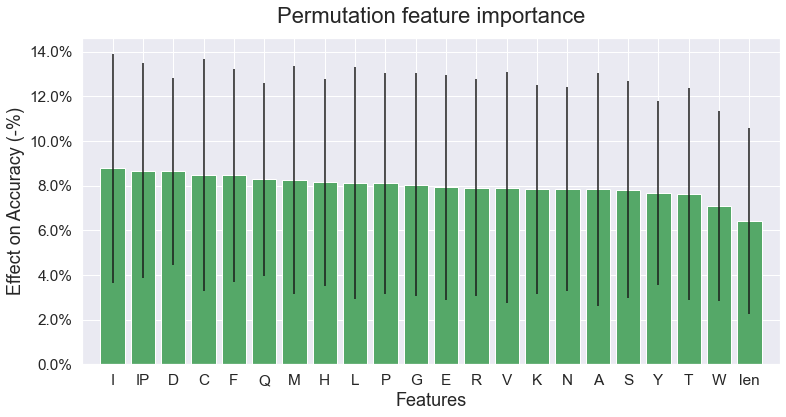

In [251]:
importances2 = perm_acc_mean
indices2 = perm_acc_mean.argsort()[::-1][:n_feat]

# Plot the feature importances of the forest
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12.5, 6))
plt.bar(range(x_train.shape[1]), importances2[indices2],
       color="g", yerr=perm_acc_std[indices2], align="center")
plt.xlabel('Features', fontsize=font2)
plt.ylabel('Effect on Accuracy (-%)', fontsize=font2)
ax.set_title('Permutation feature importance', fontsize=font1, pad=15)
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))
plt.xticks(range(x_train.shape[1]), aa[indices2])
plt.xlim([-1, n_feat])

plt.show()

fig.savefig("../results/Fig5b-RF Permutation feature importance.png")
fig.savefig("../results/Fig5b-RF Permutation feature importance.svg")

In [175]:
## Run Dropout Feature Importance Analysis

# set number of iterations
n_iter = 100
# number of features
n_feat = xTest_actual.shape[1]
# create a placeholder for the results
dropout_acc = np.zeros((n_iter, n_feat)) 


# for each of the features
for j in range(n_feat):

    for i in range(n_iter):

        # create a random shuffle of the phage table data
        shuffle_index = np.random.permutation(xTest_actual.shape[0])
        xS,yS = xTest_actual[shuffle_index], yTest_actual[shuffle_index]

        # split into an 80/20 training set
        n80 = round(nt*.80)
        n20 = nt-n80
        x_train, x_test = xS[:n80], xS[n80:]
        y_train, y_test = yS[:n80], yS[n80:]

        # copy x_train without one column
        x_train2 = np.delete(x_train, j, 1)
        x_test2 = np.delete(x_test, j, 1)
        
        # train and fit the random forest
        rfBest_clf.fit(x_train2,y_train)
        expected2 = y_test
        predicted2 = rfBest_clf.predict(x_test2)
        curr_Accuracy = accuracy_score(expected2, predicted2)

        # compare accuracy to baseline
        dropout_acc[i,j] = np.abs(curr_Accuracy-rfBest_acc)/rfBest_acc

    print("feat ", j, "complete")

feat  0 complete
feat  1 complete
feat  2 complete
feat  3 complete
feat  4 complete
feat  5 complete
feat  6 complete
feat  7 complete
feat  8 complete
feat  9 complete
feat  10 complete
feat  11 complete
feat  12 complete
feat  13 complete
feat  14 complete
feat  15 complete
feat  16 complete
feat  17 complete
feat  18 complete
feat  19 complete
feat  20 complete
feat  21 complete


In [176]:
dropout_acc_df = pd.DataFrame(dropout_acc)
dropout_acc_df.columns = feat_Columns

dropout_acc_mean = []
dropout_acc_std = []
for i in dropout_acc_df.columns:
    dropout_acc_mean.append(np.mean(dropout_acc_df[i]))
    dropout_acc_std.append(np.std(dropout_acc_df[i]))
dropout_acc_mean= np.asarray(dropout_acc_mean)
dropout_acc_std= np.asarray(dropout_acc_std)

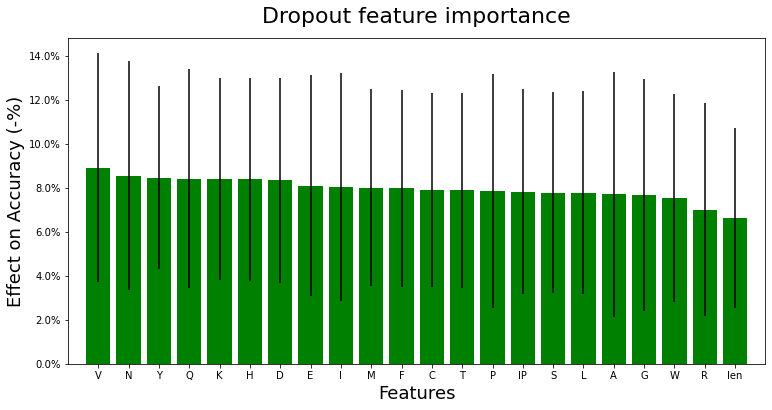

In [177]:
importances3 = dropout_acc_mean
indices3 = dropout_acc_mean.argsort()[::-1][:n_feat]

# Plot the feature importances of the forest
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12.5, 6))
plt.bar(range(x_train.shape[1]), importances3[indices3],
       color="g", yerr=dropout_acc_std[indices3], align="center")
plt.xlabel('Features', fontsize=font2)
plt.ylabel('Effect on Accuracy (-%)', fontsize=font2)
ax.set_title('Dropout feature importance', fontsize=font1, pad=15)
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))
plt.xticks(range(x_train.shape[1]), aa[indices3])
plt.xlim([-1, n_feat])

plt.show()

fig.savefig("../results/Fig5b-RF Dropout feature importance.png")
fig.savefig("../results/Fig5b-RF Dropout feature importance.svg")

In [441]:
# run the best random forest for 80/20 train/test splits on the whole database again for acc stats 

import warnings
warnings.filterwarnings("ignore")

# set number of iterations
n_iter = 10
accuracy_RFbest = []
cm_RFbest = []
aauu_RFbest = []
total_T_result= []


for i in range(n_iter):
    # create a random shuffle of the phage table data
    shuffle_index = np.random.permutation(nt)
    xS,yS = xTest_actual[shuffle_index], yTest_actual[shuffle_index]

    # split into an 80/20 training set
    n80 = round(nt*.80)
    n20 = nt-n80
    x_train, x_test = xS[:n80], xS[n80:]
    y_train, y_test = yS[:n80], yS[n80:]

    # review the accuracy
    rfBest_clf.fit(x_train, y_train)
    yPred = clf.predict(x_test)
    accuracy_RFbest.append(accuracy_score(y_test, yPred))
    accuracy_RFbest.append(mean_squared_error(y_test, yPred))
    temp_cm = confusion_matrix(y_test,yPred)
    cm_RFbest.append(temp_cm)

    # Create statistics for Assigned/Unassigned  
    # G2T and MCP2T both say elongated
    UU = temp_cm[-1,-1]
    aauu_RFbest.append(UU)
    # G2T predicts elongated, MCP2T says otherwise
    UA = np.sum(temp_cm[-1,:])-UU
    aauu_RFbest.append(UA)
    # G2T predicts icosahedral, MCP2T says elongated
    AU = np.sum(temp_cm[:,-1])-UU
    aauu_RFbest.append(AU)
    # G2T and MCP2T predict icosahedral
    AA = np.sum(temp_cm[:-1])-AU
    aauu_RFbest.append(AA)
    
    acc_count_test = []
    for j in range(y_test.shape[0]):
        T_temp = tdict2rev[y_test[j]]
        acc_count_test.append(T_temp)
        if (y_test[j]==yPred[j]):
            acc_count_test.append(1)
        else:
            acc_count_test.append(0)

    ac_test = np.asarray(np.reshape(np.ravel(acc_count_test), (-1, 2)))
    ac_test = pd.DataFrame(ac_test,columns=['T', 'result'])

    TT1 = pd.DataFrame(ac_test.groupby(['T']).sum())
    TT2 = pd.DataFrame(ac_test.groupby(['T']).count())

    TT1 = TT1.merge(TT2, how='left', on='T')
    TT1 = TT1.reset_index()

    TT1["percent"]=TT1['result_x']/TT1['result_y']

    for k in range(TT1.shape[0]):
        total_T_result.append(i)
        total_T_result.append(TT1.iloc[k]['T'])
        total_T_result.append(TT1.iloc[k]['percent'])

    
    if (i % 10 == 0):
        print('loop ',i)

# Format/df the overall accuracy and MSE statistics
rfBest_Results = np.asarray(np.reshape(np.ravel(accuracy_RFbest), (n_iter, 2)))
rfBest_Results = pd.DataFrame(rfBest_Results,columns=['accuracy_score', 'MSE'])

# Format/df the elongated/icosahedral statistics
rfBest_AAUU = np.asarray(np.reshape(np.ravel(aauu_RFbest), (n_iter, 4)))
rfBest_AAUU = pd.DataFrame(rfBest_AAUU,columns=['UU', 'UA', 'AU', 'AA'])

# Format/df the accuracy by T-number statistics
ac_test = np.asarray(np.reshape(np.ravel(total_T_result), (-1, 3)))
ac_test = pd.DataFrame(ac_test,columns=['loop','T', 'percent'])
TT1 = pd.DataFrame(ac_test.groupby(['T']).sum())
TT2 = pd.DataFrame(ac_test.groupby(['T']).count())
TT1 = TT1.merge(TT2, how='left', on='T')
TT1 = TT1.reset_index()
TT1["percent"]=TT1['percent_x']/TT1['percent_y']
avg_T_accuracy = TT1[['T', 'percent']]

loop  0


In [465]:
# use the optimized hyperparameters to train on a randomly selected 80% of the data
# then check the accuracy on the remaining 20%

import warnings
warnings.filterwarnings("ignore")

# set number of iterations
n_iter = 100
accuracy_RFbest = []
cm_RFbest = []
aauu_RFbest = []
total_T_result= []

for i in range(n_iter):
    # create a random shuffle of the phage table data
    shuffle_index = np.random.permutation(nt)
    xS,yS = xTest_actual[shuffle_index], yTest_actual[shuffle_index]
   
    # split into an 80/20 training set
    n80 = round(nt*.80)
    n20 = nt-n80
    x_train, x_test = xS[:n80], xS[n80:]
    y_train, y_test = yS[:n80], yS[n80:]

    # review the accuracy of the selected random forest 
    rfBest_clf.fit(x_train, y_train)
    yPred = rfBest_clf.predict(x_test)
    accuracy_RFbest.append(accuracy_score(y_test, yPred))
    accuracy_RFbest.append(mean_squared_error(y_test, yPred))
        
    temp_cm = confusion_matrix(y_test,yPred)
    cm_RFbest.append(temp_cm)

    # Create statistics for Assigned/Unassigned  
    # G2T and MCP2T both say elongated
    UU = temp_cm[-1,-1]
    aauu_RFbest.append(UU)
    # G2T predicts elongated, MCP2T says otherwise
    UA = np.sum(temp_cm[-1,:])-UU
    aauu_RFbest.append(UA)
    # G2T predicts icosahedral, MCP2T says elongated
    AU = np.sum(temp_cm[:,-1])-UU
    aauu_RFbest.append(AU)
    # G2T and MCP2T predict icosahedral
    AA = np.sum(temp_cm[:-1])-AU
    aauu_RFbest.append(AA)
    
    acc_count_test = []
    for j in range(y_test.shape[0]):
        T_temp = tdict2rev[y_test[j]]
        acc_count_test.append(T_temp)
        if (y_test[j]==yPred[j]):
            acc_count_test.append(1)
        else:
            acc_count_test.append(0)

    ac_test = np.asarray(np.reshape(np.ravel(acc_count_test), (-1, 2)))
    ac_test = pd.DataFrame(ac_test,columns=['T', 'result'])

    TT1 = pd.DataFrame(ac_test.groupby(['T']).sum())
    TT2 = pd.DataFrame(ac_test.groupby(['T']).count())

    TT1 = TT1.merge(TT2, how='left', on='T')
    TT1 = TT1.reset_index()

    TT1["percent"]=TT1['result_x']/TT1['result_y']

    for k in range(TT1.shape[0]):
        total_T_result.append(i)
        total_T_result.append(TT1.iloc[k]['T'])
        total_T_result.append(TT1.iloc[k]['percent'])

    
    if (i % 10 == 0):
        print('loop ',i)

# Format/df the overall accuracy and MSE statistics
rfBest_Results = np.asarray(np.reshape(np.ravel(accuracy_RFbest), (n_iter, 2)))
rfBest_Results = pd.DataFrame(rfBest_Results,columns=['accuracy_score', 'MSE'])

# Format/df the elongated/icosahedral statistics
rfBest_AAUU = np.asarray(np.reshape(np.ravel(aauu_RFbest), (n_iter, 4)))
rfBest_AAUU = pd.DataFrame(rfBest_AAUU,columns=['UU', 'UA', 'AU', 'AA'])

# Format/df the accuracy by T-number statistics
ac_test = np.asarray(np.reshape(np.ravel(total_T_result), (-1, 3)))
ac_test = pd.DataFrame(ac_test,columns=['loop','T', 'percent'])
TT1 = pd.DataFrame(ac_test.groupby(['T']).sum())
TT2 = pd.DataFrame(ac_test.groupby(['T']).count())
TT1 = TT1.merge(TT2, how='left', on='T')
TT1 = TT1.reset_index()
TT1["percent"]=TT1['percent_x']/TT1['percent_y']
avg_T_accuracy = TT1[['T', 'percent']]


loop  0
loop  10
loop  20
loop  30
loop  40
loop  50
loop  60
loop  70
loop  80
loop  90


In [466]:
avg_acc = np.mean(rfBest_Results["accuracy_score"])
print("Average Accuracy across %d runs: %.3f" % (n_iter, avg_acc))
print("Average MSE across %d runs: %.3f" % (n_iter, np.mean(rfBest_Results["MSE"])))

Average Accuracy across 100 runs: 0.730
Average MSE across 100 runs: 211.375


In [467]:
print("MCP2T correctly predicts %d icosahedral structures, accounting for %.3f of all predictions" % (np.mean(rfBest_AAUU["AA"]),np.mean(rfBest_AAUU["AA"])/n20))
print("MCP2T correctly predicts %d elongated structures, accounting for %.3f of all predictions" % (np.mean(rfBest_AAUU["UU"]),np.mean(rfBest_AAUU["UU"])/n20))
print("MCP2T incorrectly predicts %d elongated structures as icosahedral, accounting for %.3f of all predictions" % (np.mean(rfBest_AAUU["UA"]),np.mean(rfBest_AAUU["UA"])/n20))
print("MCP2T incorrectly predicts %d icosahedral structures as elongated, accounting for %.3f of all predictions" % (np.mean(rfBest_AAUU["AU"]),np.mean(rfBest_AAUU["AU"])/n20))


MCP2T correctly predicts 99 icosahedral structures, accounting for 0.784 of all predictions
MCP2T correctly predicts 12 elongated structures, accounting for 0.096 of all predictions
MCP2T incorrectly predicts 10 elongated structures as icosahedral, accounting for 0.079 of all predictions
MCP2T incorrectly predicts 5 icosahedral structures as elongated, accounting for 0.041 of all predictions


In [468]:
# move the elongated structures to the end
avg_T_accuracy = avg_T_accuracy.append(avg_T_accuracy.iloc[0])
avg_T_accuracy = avg_T_accuracy.reset_index()
avg_T_accuracy = avg_T_accuracy.drop(0)

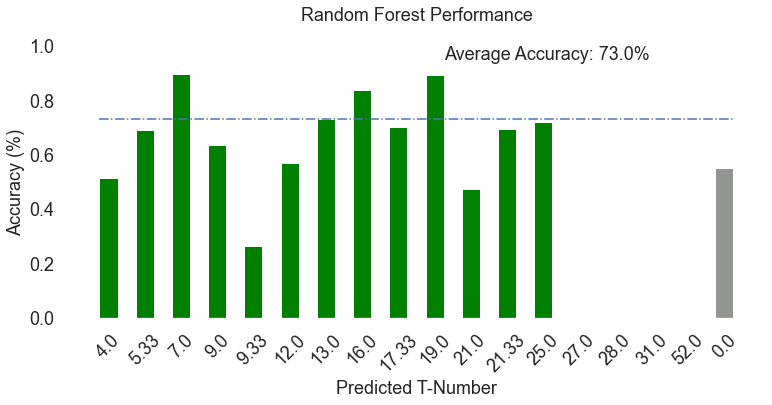

In [471]:
ind = np.arange(avg_T_accuracy.shape[0])    # the x locations for the groups
width = 0.5 

# create a color map to make the 'No T' group gray
barColors = []
for p in ind:
    if (p==np.max(ind)):
        barColors.append('#929591')
    else:
        barColors.append('green')
barColors = np.asarray(barColors)  

# plot the histogram
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12.5,5))
ax.set_facecolor('xkcd:white')
plt.xlabel('Predicted T-Number', fontsize=font2)
plt.ylabel('Accuracy (%)', fontsize=font2)
ax.set_title('Random Forest Performance', fontsize=font2, pad=25)

plt.plot((-.25,max(ind)+.25),(avg_acc,avg_acc),'-.')
DNAfb = "Average Accuracy: " + str((round(avg_acc*100,1))) + '%'
plt.text(9.25,.95, DNAfb, {'fontsize': font2})
plt.ylim(0,1)

plt.bar(ind,avg_T_accuracy['percent'], width, align='center',color=barColors)
plt.xticks(ind, avg_T_accuracy['T'], fontsize=font2)
plt.xticks(ind, avg_T_accuracy['T'], fontsize=font2, rotation=45)
plt.yticks(fontsize=font2)
ax.tick_params(length=10, width=2)
plt.savefig("../results/Fig5a-RF Predicted T-numbers for MCP.png")
plt.savefig("../results/Fig5a-RF Predicted T-numbers for MCP.svg");

In [493]:
# saves kernel state
import dill
dill.dump_session('fig6_revisit_grid_search.db')

In [494]:
# if you need to rerun this section to the end, load the above kernel state first
# create a random shuffle of the phage table data
shuffle_index = np.random.permutation(nt)
xS,yS = xTest_actual[shuffle_index], yTest_actual[shuffle_index]
splits = 20
n_iter = 100

incrementalRF = np.zeros((splits-1,5))

for i in range(splits-1):
    # split into training and test sets
    nTr = round(nt/splits*(i+1))
    nTe = nt-nTr
    incr2 = np.zeros((n_iter,2))

    for j in range(n_iter): 

        shuffle_index = np.random.permutation(nt)
        xS,yS = xTest_actual[shuffle_index], yTest_actual[shuffle_index]

        x_train, x_test = xS[:nTr], xS[nTr:]
        y_train, y_test = yS[:nTr], yS[nTr:]

        rfBest_clf.fit(x_train, y_train)
        yPred = rfBest_clf.predict(x_test)
        incr2[j][0] = mean_squared_error(y_test, yPred) 
        incr2[j][1] = accuracy_score(y_test, yPred, normalize=True, sample_weight=None)

    incrementalRF[i][0] = nTr
    incrementalRF[i][1] = np.mean(incr2[:,0])
    incrementalRF[i][2] = np.mean(incr2[:,1])
    incrementalRF[i][3] = np.std(incr2[:,1])
    incrementalRF[i][4] = np.std(incr2[:,1])/(np.sqrt(incr2.shape[0]))
    
    print("nTr", nTr, "complete")
    
print("nTr -- mse -- accuracy -- acc std dev -- acc std err")
print(incrementalRF)

nTr 32 complete
nTr 64 complete
nTr 95 complete
nTr 127 complete
nTr 159 complete
nTr 190 complete
nTr 222 complete
nTr 254 complete
nTr 286 complete
nTr 318 complete
nTr 349 complete
nTr 381 complete
nTr 413 complete
nTr 444 complete
nTr 476 complete
nTr 508 complete
nTr 540 complete
nTr 572 complete
nTr 603 complete
nTr -- mse -- accuracy -- acc std dev -- acc std err
[[ 32.    409.998   0.409   0.055   0.005]
 [ 64.    331.265   0.502   0.029   0.003]
 [ 95.    306.553   0.547   0.028   0.003]
 [127.    282.923   0.588   0.024   0.002]
 [159.    265.696   0.611   0.022   0.002]
 [190.    259.713   0.63    0.024   0.002]
 [222.    247.226   0.649   0.022   0.002]
 [254.    239.681   0.662   0.024   0.002]
 [286.    236.504   0.672   0.026   0.003]
 [318.    237.915   0.682   0.025   0.002]
 [349.    227.86    0.694   0.024   0.002]
 [381.    230.86    0.698   0.024   0.002]
 [413.    225.026   0.706   0.024   0.002]
 [444.    224.966   0.717   0.027   0.003]
 [476.    212.317   0.723

Text(0, 0.5, '% accuracy')

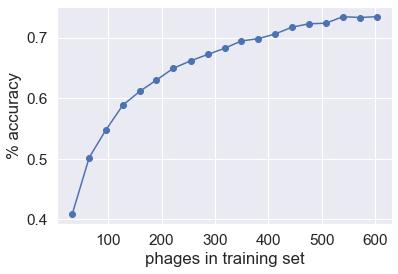

In [495]:
plt.plot(incrementalRF[:,0],incrementalRF[:,2])
plt.scatter(incrementalRF[:,0],incrementalRF[:,2])
plt.xlabel("phages in training set")
plt.ylabel("% accuracy")

In [496]:
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, explained_variance_score

from scipy.optimize import least_squares
# fit the mean relative error data to a exponential model

# Define the function computing residuals for least-squares minimization:
# y = a*(1-e^(-bx)) + cx + d, with ab as a vector of len 4 holding the initial guesses for those coefficients
def fun(ab, x1, MSE):
    return (ab[0]*(1-np.exp(-ab[1]*x1)))+ab[2]*x1 + ab[3]-MSE


# use an estimate for a starting point
abNought = [1,1,1,1]

# robust least squares model (less prone to outlier error)
res_robust = least_squares(fun, abNought, loss='soft_l1', f_scale=0.1, args=(incrementalRF[:,0],incrementalRF[:,2]))

# generate plot data for least squares and robust least squares
xlinD1 = np.linspace(0.1,650, 1000)
ylinDrls = (res_robust.x[0]*(1-np.exp(-res_robust.x[1]*xlinD1)))+res_robust.x[2]*xlinD1+res_robust.x[3]

# create an array to hold the coefficients
MSE_coeff = np.zeros(4)
for i in range(4):
    MSE_coeff[i]=round(res_robust.x[i],4)

# create text string for the function using calculated coefficients
A_coef = str(round(res_robust.x[0],6))
B_coef = str(round(res_robust.x[1],6))
C_coef = str(round(res_robust.x[2],6))
D_coef = str(round(res_robust.x[3],6))
#D_coef = str("{0:.1E}".format(res_robust.x[3]))

A_txt = "A = " + A_coef 
B_txt = "B = " + B_coef 
C_txt = "C = " + C_coef
D_txt = "D = " + D_coef

MSEr = "y = "+ A_coef + " 1-e^(-" + B_coef + "x) " + C_coef+ "x +" + D_coef
print(MSEr)

# find r-squared
r2_y1rls = res_robust.x[0]*(1-(np.exp(-res_robust.x[1]*incrementalRF[:,0])))+res_robust.x[2]*incrementalRF[:,0]+res_robust.x[3]
DNAr3= '= ' + str(round(r2_score(incrementalRF[:,2], r2_y1rls),3))

print('R-squared, robust least squares: %.4f' % r2_score(incrementalRF[:,2], r2_y1rls))

y = 0.09071 1-e^(-0.707548x) 0.000423x +0.431058
R-squared, robust least squares: 0.8037


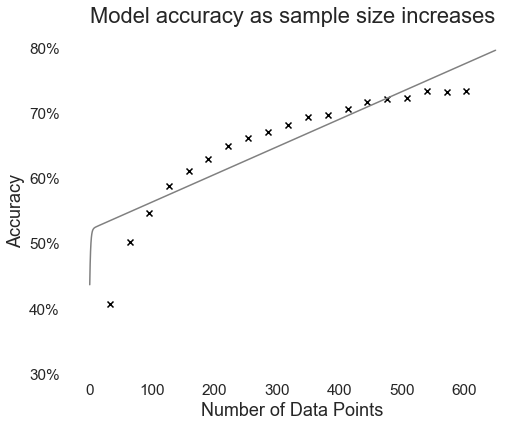

In [497]:
from matplotlib.ticker import PercentFormatter

# plot results
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
ax.set_facecolor('xkcd:white')
#fig.patch.set_facecolor('xkcd:light gray')
plt.scatter(incrementalRF[:,0],incrementalRF[:,2], label='data', marker="x", color="black")
# using std error for the error bars
#plt.errorbar(incrementalRF[:,0],incrementalRF[:,2], yerr=incrementalRF[:,4], fmt='o',capsize=5)
# using standard deviation for the error bars
#plt.errorbar(incrementalRF[:,0],incrementalRF[:,2], yerr=incrementalRF[:,3], fmt='o',capsize=5)
plt.plot(xlinD1, ylinDrls, label='robust least squares fit', color="gray")
plt.xlabel('Number of Data Points', fontsize=font2)
plt.ylabel('Accuracy', fontsize=font2)
ax.set_title('Model accuracy as sample size increases', fontsize=font1, pad=25)
plt.ylim(.3,.8)
#plt.legend(loc="upper right")

ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))


In [498]:
# fit the accuracy data to a exponential model

from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, explained_variance_score
from scipy.optimize import least_squares

# Define the function computing residuals for least-squares minimization:
# y = a*ln(x) + d, with ab as a vector of len 2 holding the initial guesses for those coefficients
def fun(ab, x1, MSE):
    return (ab[0]*np.log(x1)) + ab[1]-MSE


# use an estimate for a starting point
abNought = [1,1]

# robust least squares model (less prone to outlier error)
res_robust = least_squares(fun, abNought, loss='soft_l1', f_scale=0.1, args=(incrementalRF[:,0],incrementalRF[:,2]))

# generate plot data for least squares and robust least squares
xlinD1 = np.linspace(0.1,700, 1001)
ylinDrls = (res_robust.x[0]*(np.log(xlinD1)))+res_robust.x[1]

# create an array to hold the coefficients
MSE_coeff = np.zeros(2)
for i in range(2):
    MSE_coeff[i]=round(res_robust.x[i],4)

# create text string for the function using calculated coefficients
A_coef = str(round(res_robust.x[0],6))
D_coef = str(round(res_robust.x[1],6))
#D_coef = str("{0:.1E}".format(res_robust.x[1]))

A_txt = "A = " + A_coef 
D_txt = "D = " + D_coef

MSEr = "y = "+ A_coef + " ln(x) " + D_coef
print(MSEr)

# find r-squared
r2_y1rls = (res_robust.x[0]*(np.log(incrementalRF[:,0])))+res_robust.x[1]
DNAr3= '= ' + str(round(r2_score(incrementalRF[:,2], r2_y1rls),3))

print('R-squared, robust least squares: %.4f' % r2_score(incrementalRF[:,2], r2_y1rls))

y = 0.109552 ln(x) 0.047798
R-squared, robust least squares: 0.9917


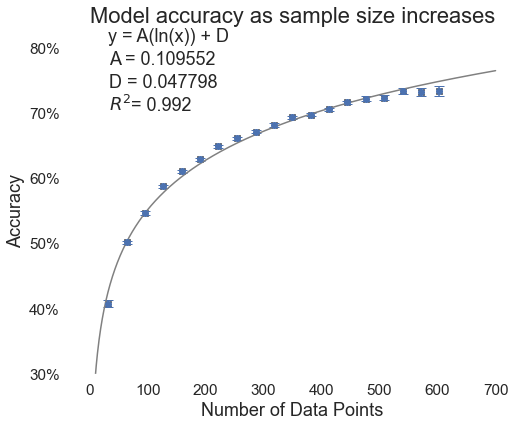

In [499]:
from matplotlib.ticker import PercentFormatter

# plot results
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
ax.set_facecolor('xkcd:white')
#fig.patch.set_facecolor('xkcd:light gray')
plt.scatter(incrementalRF[:,0],incrementalRF[:,2], label='data', marker="x", color="black")
# using std error for the error bars
plt.errorbar(incrementalRF[:,0],incrementalRF[:,2], yerr=incrementalRF[:,4], fmt='o',capsize=5)
# using standard deviation for the error bars
#plt.errorbar(incrementalRF[:,0],incrementalRF[:,2], yerr=incrementalRF[:,3], fmt='o',capsize=5)
plt.plot(xlinD1, ylinDrls, label='robust least squares fit', color="gray")
plt.xlabel('Number of Data Points', fontsize=font2)
plt.ylabel('Accuracy', fontsize=font2)
ax.set_title('Model accuracy as sample size increases', fontsize=font1, pad=25)
plt.ylim(.3,.8)
#plt.legend(loc="upper right")

txt_strtY = max(incrementalRF[:,2])+.075
txt_strtX = min(incrementalRF[:,0])

#plt.text(min(D_err[:,0]+2), max(D_err[:,1]), MSEr, {'fontsize': font2})
plt.text(txt_strtX, txt_strtY, "y = A(ln(x)) + D", {'fontsize': font2})
plt.text(txt_strtX+1, txt_strtY-.035, A_txt, {'fontsize': font2})
plt.text(txt_strtX+1, txt_strtY-.070, D_txt, {'fontsize': font2})
plt.text(txt_strtX+1, txt_strtY-.105, (r'$R^2$'), {'fontsize': font2})
plt.text(txt_strtX+40, txt_strtY-.105, DNAr3, {'fontsize': font2})


ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))


In [500]:
def errorModel(xVal):
    return (res_robust.x[0]*(np.log(xVal)))+res_robust.x[1]

In [501]:
# custom function to numerically find the sample size necessary to hit a specific error percentage based on the error model
# input arguments are the guess for what the x might be, and the y target range

def numericalErrFinder(y_target, x_target, currentErr=100):

    x_guess = copy.copy(x_target)
    x_init = x_target-20
    x_final = x_target+20
    
    for i in range(x_init-1,x_final+1):
        if abs((errorModel(i))-y_target) < currentErr:
            currentErr = abs((errorModel(i))-y_target) 
            x_guess = i
#            print(currentErr)
#            print(x_guess)
      
    if (x_guess == x_final or x_guess == x_init-1):
        x_guess = numericalErrFinder(y_target, x_guess, currentErr)
    
    return x_guess

In [502]:
numericalErrFinder(.8,1000)

959

In [503]:
numericalErrFinder(.9,1000)

2390

In [504]:
errorModel(nt)

0.7548042145102234

In [505]:
print("nTr -- mse -- accuracy -- acc std dev -- acc std err")
print(incrementalRF)

nTr -- mse -- accuracy -- acc std dev -- acc std err
[[ 32.    409.998   0.409   0.055   0.005]
 [ 64.    331.265   0.502   0.029   0.003]
 [ 95.    306.553   0.547   0.028   0.003]
 [127.    282.923   0.588   0.024   0.002]
 [159.    265.696   0.611   0.022   0.002]
 [190.    259.713   0.63    0.024   0.002]
 [222.    247.226   0.649   0.022   0.002]
 [254.    239.681   0.662   0.024   0.002]
 [286.    236.504   0.672   0.026   0.003]
 [318.    237.915   0.682   0.025   0.002]
 [349.    227.86    0.694   0.024   0.002]
 [381.    230.86    0.698   0.024   0.002]
 [413.    225.026   0.706   0.024   0.002]
 [444.    224.966   0.717   0.027   0.003]
 [476.    212.317   0.723   0.037   0.004]
 [508.    209.846   0.724   0.038   0.004]
 [540.    203.816   0.734   0.042   0.004]
 [572.    213.987   0.733   0.059   0.006]
 [603.    223.793   0.734   0.077   0.008]]


In [506]:
# estimate error on the curve fitting for the mean relative error by bootstrapping the data

# set the number of sample runs
n_iter = 1000

# create placeholders for the mean, variance, and standard deviation at each data point for each iteration
error_calc1 = np.zeros((n_iter,2))  # error calculations using the variance as the limits for selecting data
error_calc2 = np.zeros((n_iter,2))  # error calcs using the standard deviation


for j in range(n_iter):
    # create a placeholder for the new generated dataset
    coef_err = np.zeros((incrementalRF.shape[0],3))  
    for i in range(incrementalRF.shape[0]):
        # copy the x data point
        coef_err[i][0] = incrementalRF[i][0]
        # draw a random point within the standard error
        coef_err[i][1] = random.randint(-100,100)/100*incrementalRF[i][4]+incrementalRF[i][1]
        # draw a random point within the standard deviation
        coef_err[i][2] = random.randint(-100,100)/100*incrementalRF[i][3]+incrementalRF[i][1]

    # create a robust least squares model based on standard error dataset
    res_robust_bs1 = least_squares(fun, abNought, loss='soft_l1', f_scale=0.1, args=(coef_err[:,0],coef_err[:,1]))
    # create a robust least squares model based on standard deviation dataset
    res_robust_bs2 = least_squares(fun, abNought, loss='soft_l1', f_scale=0.1, args=(coef_err[:,0],coef_err[:,2]))

    # capture the calculated model coefficients
    for i in range(2):
        error_calc1[j][i]=res_robust_bs1.x[i]
        error_calc2[j][i]=res_robust_bs2.x[i]
        
#    print(error_calc1)
#    print(error_calc2)

# hold stats on error spread
final_err1 = np.zeros((2,4))
final_err2 = np.zeros((2,4))


for i in range(2):
    # calculate mean, variance, standard deviation, and standard error
    final_err1[i][0]=np.mean(error_calc1[:,i])
    final_err1[i][1]=statistics.variance(error_calc1[:,i])
    final_err1[i][2]=np.std(error_calc1[:,i])
    final_err1[i][3]=np.std(error_calc1[:,i])/(np.sqrt(incrementalRF.shape[0]-1))

    final_err2[i][0]=np.mean(error_calc2[:,i])
    final_err2[i][1]=statistics.variance(error_calc2[:,i])
    final_err2[i][2]=np.std(error_calc2[:,i])
    final_err2[i][3]=np.std(error_calc2[:,i])/(np.sqrt(incrementalRF.shape[0]-1))
    
    # smooth any of the data points that are extreme outliers from fitting errors in the std dev set
#    xTx100 = np.asarray([k for k in error_calc2[:,i] if (abs(k) < 10)])
#    final_err2[i][0]=np.mean(xTx100)
#    final_err2[i][1]=statistics.variance(xTx100)
#    final_err2[i][2]=np.std(xTx100)
#    final_err2[i][3]=np.std(xTx100)/(np.sqrt(len(xTx100)))

print("standard error-based bootstrap")
print("mean - var - stddev - std err")
print(final_err1)
print("standard deviation-based bootstrap")
print("mean - var - stddev - std err")
print(final_err2)

standard error-based bootstrap
mean - var - stddev - std err
[[-57.742   0.      0.002   0.   ]
 [569.482   0.      0.008   0.002]]
standard deviation-based bootstrap
mean - var - stddev - std err
[[-57.742   0.      0.016   0.004]
 [569.483   0.007   0.085   0.02 ]]


In [507]:
##### print the std err error 
A_txt2 = round(final_err2[0][3],6)
D_txt2 = round(final_err2[1][3],6)

print(A_txt2)
print(D_txt2)

# print the std err error rounded to the correct sig fig 
A_txt2 = str(round(final_err2[0][3],3))
D_txt2 = str(round(final_err2[1][3],2))
#D_txt2 = str("{0:.1e}".format(round(final_err1[3][3],2)))

print(A_txt2)
print(D_txt2)


0.003849
0.020023
0.004
0.02


In [508]:
# print the coefficients at the correct sig fig based on error
A_coef = str(round(res_robust.x[0],3))
D_coef = str(round(res_robust.x[1],2))

MSEr = "y = "+ A_coef + "(ln(x)) + " + D_coef
print(MSEr)

A_txt = "A = " + A_coef 
D_txt = "D = " + D_coef

y = 0.11(ln(x)) + 0.05


In [509]:
A_test1 = "A = "+str(round(res_robust.x[0],3)*100)
AE_test1 = str(round(final_err2[0][3]*100,1))+"" 
AE_test2 = ""

D_test1 = "D = "+str(round(res_robust.x[1],3)*100)
DE_test1 = str(round(final_err2[1][3],2)*100)+"" 
DE_test2 = ""


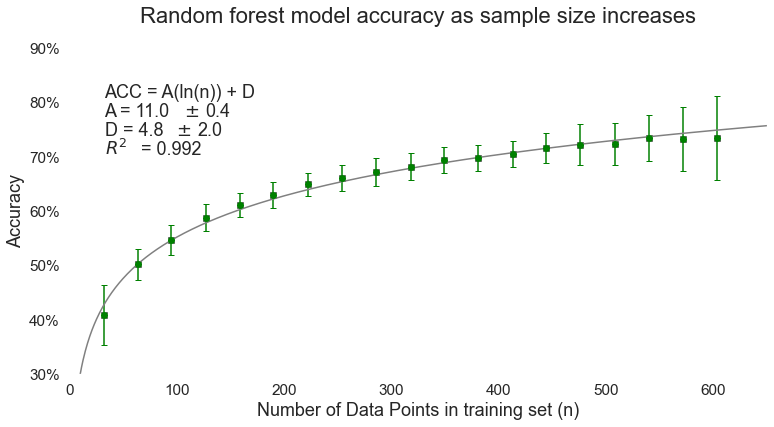

In [510]:
 # plot results
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12.5, 6))
ax.set_facecolor('xkcd:white')
#fig.patch.set_facecolor('xkcd:light gray')
# using std error for the error bars
#plt.errorbar(incrementalRF[:,0],incrementalRF[:,2], yerr=incrementalRF[:,4], fmt='o',capsize=3, capthick=1)
# using standard deviation for the error bars
plt.plot(xlinD1, ylinDrls, label='robust least squares fit', color="gray")
plt.errorbar(incrementalRF[:,0],incrementalRF[:,2], yerr=incrementalRF[:,3], fmt='o',capsize=3, color='green', ecolor='green', capthick=1)
plt.scatter(incrementalRF[:,0],incrementalRF[:,2], label='data', marker="x", color="black")
plt.xlabel('Number of Data Points in training set (n)', fontsize=font2)
plt.ylabel('Accuracy', fontsize=font2)
ax.set_title('Random forest model accuracy as sample size increases', fontsize=font1, pad=25)
plt.ylim(.3,.9)
plt.xlim(0,650)
#plt.legend(loc="upper right")

txt_strtY = max(incrementalRF[:,2])+.075
txt_strtX = min(incrementalRF[:,0])

#plt.text(min(D_err[:,0]+2), max(D_err[:,1]), MSEr, {'fontsize': font2})
plt.text(txt_strtX, txt_strtY, "ACC = A(ln(n)) + D", {'fontsize': font2})
plt.text(txt_strtX, txt_strtY-.035, A_test1, {'fontsize': font2})
plt.text(txt_strtX+75, txt_strtY-.035, (r'$\pm$'), {'fontsize': font2})
plt.text(txt_strtX+95, txt_strtY-.035, AE_test1, {'fontsize': font2})
plt.text(txt_strtX+145, txt_strtY-.025, AE_test2, {'fontsize': font3})

plt.text(txt_strtX+1, txt_strtY-.07, D_test1, {'fontsize': font2})
plt.text(txt_strtX+67, txt_strtY-.07, (r'$\pm$'), {'fontsize': font2})
plt.text(txt_strtX+87, txt_strtY-.07, DE_test1, {'fontsize': font2})
plt.text(txt_strtX+137, txt_strtY-.06, DE_test2, {'fontsize': font3})


plt.text(txt_strtX+1, txt_strtY-.105, (r'$R^2$'), {'fontsize': font2})
plt.text(txt_strtX+35, txt_strtY-.105, DNAr3, {'fontsize': font2})


ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))
fig.savefig("../results/Fig5c-RF model Rarification.png")
fig.savefig("../results/Fig5c-RF model Rarification.svg")

In [511]:
# saves kernel state
import dill
dill.dump_session('fig6_revisit_grid_search2.db')

In [4]:
# import kernel state
#import dill
#dill.load_session('fig6_revisit_grid_search2.db')

In [512]:
avg_T_accuracy

,index,T,percent
1,1,4.00,0.514561
2,2,5.33,0.690492
3,3,7.00,0.895303
4,4,9.00,0.637096
5,5,9.33,0.263636
6,6,12.00,0.569611
7,7,13.00,0.731944
8,8,16.00,0.837699
9,9,17.33,0.702578
10,10,19.00,0.894930


In [ ]:
shuffle_index = np.random.permutation(nt)
xS,yS = xTest_actual[shuffle_index], yTest_actual[shuffle_index]

# split into an 80/20 training set
n80 = round(nt*.80)
n20 = nt-n80
x_train, x_test = xS[:n80], xS[n80:]
y_train, y_test = yS[:n80], yS[n80:]

# Train
rfBest_clf.fit(x_train, y_train)

In [18]:
from sklearn import tree
from dtreeviz.trees import dtreeviz

In [19]:
aa = np.asarray(['IP','len','A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V'])

In [59]:
yy = []
for i in y_train:
    yy.append(tdict2rev[i])
yy = np.sort(np.unique(yy))
yy2 = []
for i in range(len(yy)):
    yy2.append(str(yy[i]))

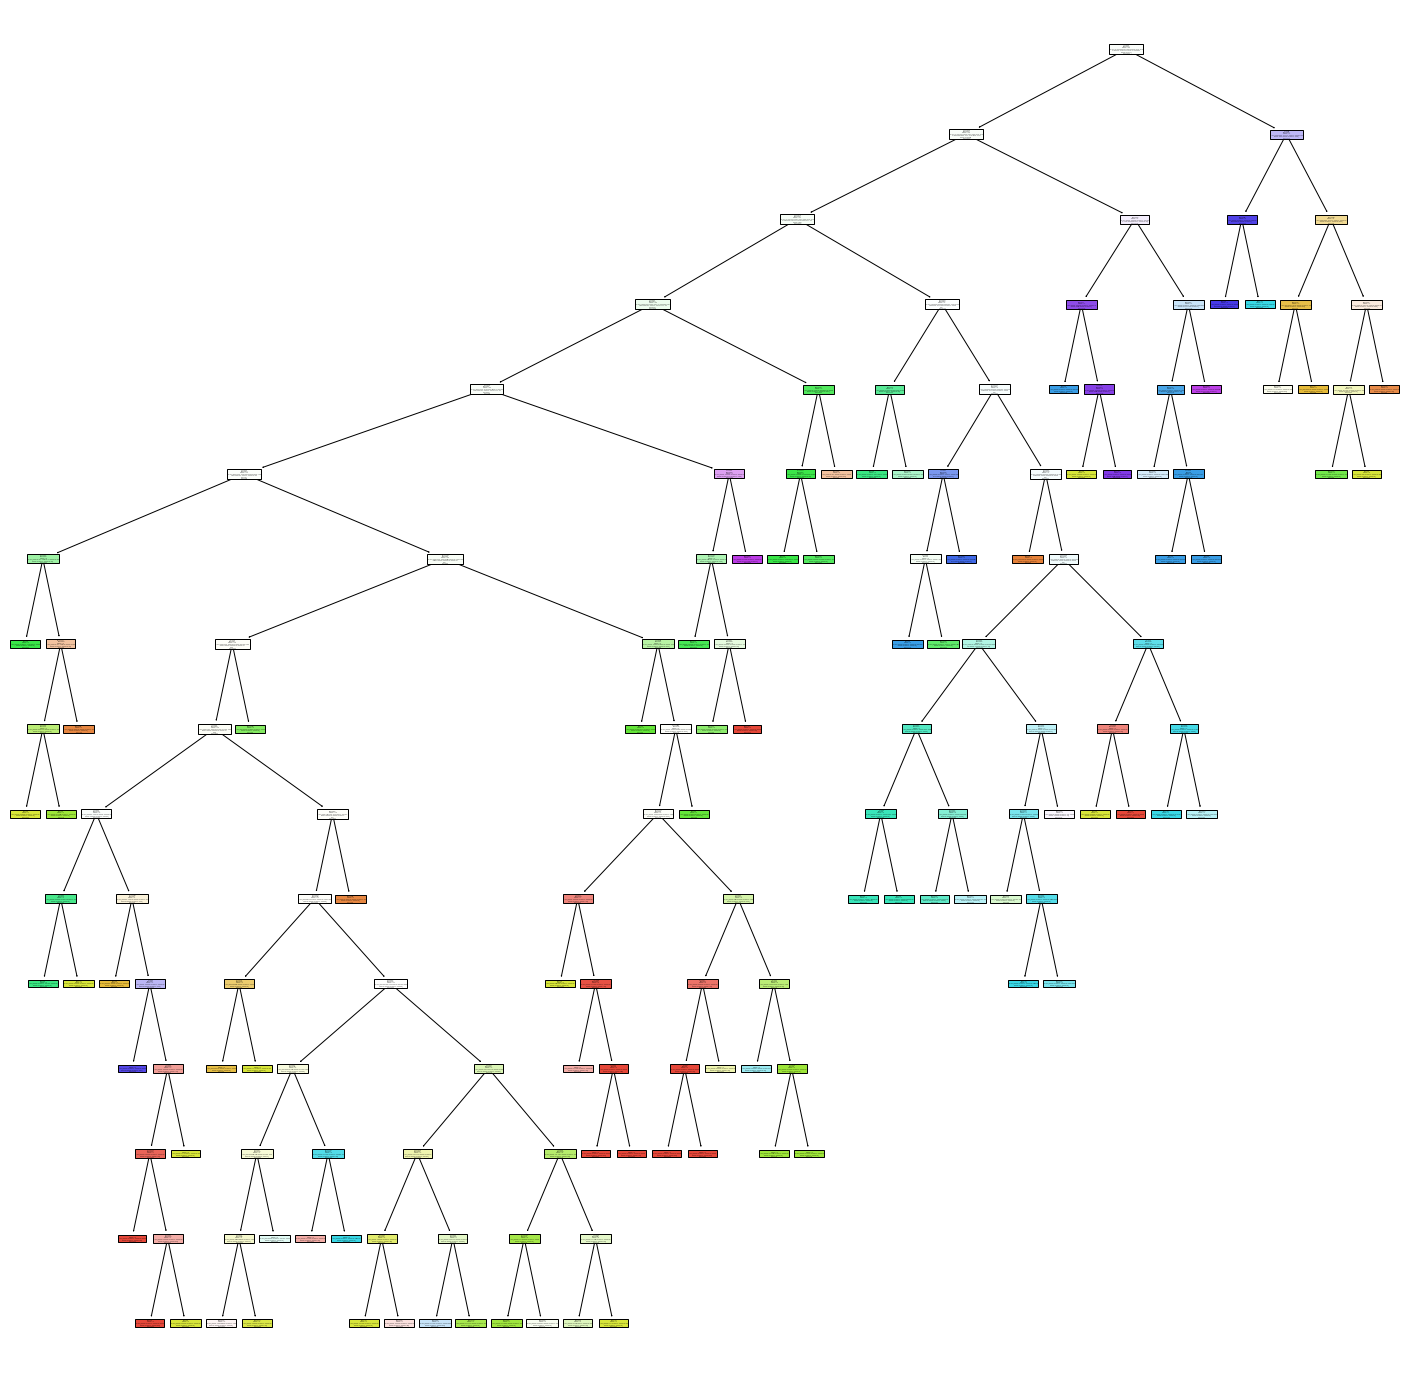

In [60]:
plt.figure(figsize=(25,25))
_ = tree.plot_tree(rfBest_clf.estimators_[0], feature_names=aa, class_names= yy2, filled=True)

fig.savefig("../results/Fig5d-RF single tree visualization.svg")

[Text(671.3820512180511, 526.6125000000001, 'L <= 0.099\ngini = 0.929\nsamples = 316\nvalue = [32.254, 29.882, 29.11, 23.615, 36.286, 46.182, 31.75\n25.303, 35.85, 28.709, 14.111, 37.63, 28.222, 28.222\n0.0, 0.0, 0.0, 22.77]\nclass = 19.0'),
 Text(575.291258985623, 492.63750000000005, 'len <= 505.5\ngini = 0.924\nsamples = 289\nvalue = [28.222, 13.281, 25.382, 23.615, 34.27, 46.182, 31.75\n25.303, 34.324, 28.709, 14.111, 4.704, 28.222, 28.222\n0.0, 0.0, 0.0, 21.808]\nclass = 19.0'),
 Text(474.0298023162939, 458.6625, 'len <= 437.5\ngini = 0.914\nsamples = 253\nvalue = [28.222, 13.281, 24.317, 23.615, 34.27, 46.182, 31.75\n25.303, 32.799, 7.299, 14.111, 4.704, 3.136, 14.111, 0.0\n0.0, 0.0, 21.808]\nclass = 19.0'),
 Text(387.1626397763578, 424.6875, 'F <= 0.054\ngini = 0.878\nsamples = 195\nvalue = [10.079, 13.281, 23.785, 23.615, 28.222, 43.616, 7.056\n1.946, 6.865, 1.946, 0.0, 4.704, 0.0, 14.111, 0.0, 0.0\n0.0, 20.205]\nclass = 19.0'),
 Text(287.6351837060703, 390.7125, 'G <= 0.103\ngi

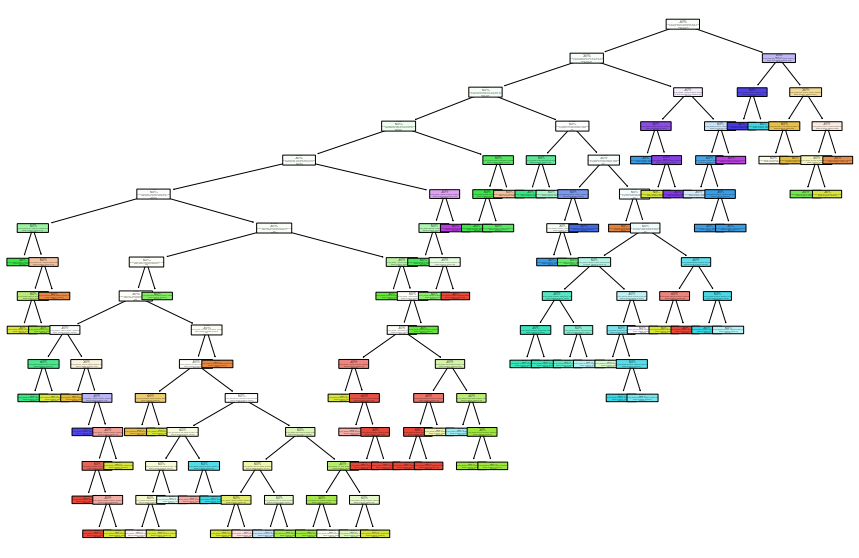

In [41]:
from sklearn.tree import plot_tree

fig = plt.figure(figsize=(15, 10))
plot_tree(rfBest_clf.estimators_[0], 
          feature_names=aa,
          class_names=yy,
          filled=True, impurity=True, 
          rounded=True)